In [ ]:
!pip install javalang pandas
!pip install pandas

In [ ]:
!git clone https://github.com/microsoft/InferredBugs.git

Cloning into 'InferredBugs'...
remote: Enumerating objects: 60601, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 60601 (delta 420), reused 164 (delta 163), pack-reused 60167 (from 1)
Receiving objects: 100% (60601/60601), 58.70 MiB | 5.64 MiB/s, done.
Resolving deltas: 100% (7358/7358), done.
Updating files: 100% (67123/67123), done.


In [ ]:
import os
import json
import pandas as pd
import re
from google.colab import files
from google.colab import files as colab_files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc



In [ ]:
def check_memory_leak_features(code_snippet):
    features = {
         "public_constructor": "public constructor" in code_snippet,
        "static_instance_variable": "static " in code_snippet,
        "multiple_instances": code_snippet.count("new ") > 1,
        "direct_constructor_call_outside": "new " in code_snippet,
        "missing_finally_blocks": "finally" not in code_snippet,
        "no_try_with_resources": "try (" not in code_snippet,
        "no_explicit_close": "close()" not in code_snippet,
        "no_close_call": "close()" not in code_snippet,
        "exceptions_not_handled": "catch (" not in code_snippet,
        "present_non_static_inner_classes": "class " in code_snippet and "static" not in code_snippet,
        "usage_of_ThreadLocals_set_null": "ThreadLocals.set(null)" in code_snippet,

        "null_check_missing": "== null" in code_snippet and "if" not in code_snippet,
        "uninitialized_variables": "null" in code_snippet and ";" in code_snippet,
        "method_called_on_null": code_snippet.count("->") > 1 and "null" in code_snippet,
        "no_null_return_handling": "return null;" in code_snippet and "if" not in code_snippet,
        "null_check_after_dereference": "== null" in code_snippet and code_snippet.index("== null") > code_snippet.index("."),
    }

    # comments with keywords
    comment_keywords = re.findall(r'//.*\b(TODO|FIXME|HACK)\b', code_snippet, re.IGNORECASE)
    features["comments_with_keywords"] = len(comment_keywords) > 0

    # shared resources without synchronization
    shared_resources = re.findall(r'\b(List|HashMap|HashSet|Vector)\b', code_snippet)
    sync_blocks = re.findall(r'\bsynchronized\b', code_snippet)
    features["shared_resources_no_sync"] = len(shared_resources) > 0 and len(sync_blocks) == 0

    # num vars set to null
    variables_set_to_null = re.findall(r'=\s*null\b', code_snippet)
    features["num_variables_set_to_null"] = len(variables_set_to_null)

    # num resource allocations
    resource_allocations = re.findall(r'\bnew\b', code_snippet)
    features["num_resource_allocations"] = len(resource_allocations)

    # num null checks
    null_checks = re.findall(r'\bnull\b\s*(==|!=)', code_snippet)
    features["num_null_checks"] = len(null_checks)

    # num mutable objects used
    mutable_objects = re.findall(r'\b(ArrayList|HashMap|HashSet|LinkedList|Vector)\b', code_snippet)
    features["num_mutable_objects_used"] = len(mutable_objects)

    #Presence of Nullability Annotations
    nullable_annotations = re.findall(r'@\b(Nullable|NonNull)\b', code_snippet)
    features["nullability_annotations"] = len(nullable_annotations) > 0

    return features

In [ ]:
java_directory = '/content/InferredBugs/inferredbugs/java'

# Use 1 for resource leak and 0 for null dereference
memory_leak_and_null_dereference = {}

for root, dirs, files in os.walk(java_directory):
    for file in files:
        if file == 'bug.json':
            bug_file_path = os.path.join(root, file)
            with open(bug_file_path, 'r') as bug_file:
                bug_data = json.load(bug_file)
                if bug_data.get('bug_type') == 'RESOURCE_LEAK':
                  # memory_leak_and_null_dereference.append(bug_file_path)
                  memory_leak_and_null_dereference[bug_file_path] = 1
                elif bug_data.get('bug_type') == 'NULL_DEREFERENCE':
                  memory_leak_and_null_dereference[bug_file_path] = 0

In [ ]:
features_list = []


for leak_file, bug_type in memory_leak_and_null_dereference.items():
    leak_directory = os.path.dirname(leak_file)
    code_file_path = os.path.join(leak_directory, 'file_before.txt')

    if os.path.exists(code_file_path):
        with open(code_file_path, 'r') as code_file:
            code_snippet = code_file.read()
            features = check_memory_leak_features(code_snippet)
            features['file_name'] = os.path.relpath(leak_directory, java_directory) + '/file_before.txt'
            features["bug_type"] = bug_type
            features_list.append(features)



In [ ]:
features_df = pd.DataFrame(features_list)

In [ ]:
if not features_df.empty:
    csv_file_path_memory = '/content/memory_leak_null_dereference_features.csv'
    features_df.to_csv(csv_file_path_memory, index=False)

    print(f'Saved features to {csv_file_path_memory}')

    try:
        colab_files.download(csv_file_path_memory)
    except Exception as e:
        print(f"An error occurred while downloading: {e}")
else:
    print("No features extracted. DataFrame is empty.")

Saved features to /content/memory_leak_null_dereference_features.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
features_df.shape

(6237, 25)

In [ ]:
features_df.head()

,public_constructor,static_instance_variable,multiple_instances,direct_constructor_call_outside,missing_finally_blocks,no_try_with_resources,no_explicit_close,no_close_call,exceptions_not_handled,present_non_static_inner_classes,...,null_check_after_dereference,comments_with_keywords,shared_resources_no_sync,num_variables_set_to_null,num_resource_allocations,num_null_checks,num_mutable_objects_used,nullability_annotations,file_name,bug_type
0,False,True,True,True,False,True,False,False,False,False,...,True,True,False,9,19,0,2,False,java-apns/5/file_before.txt,1
1,False,True,True,True,True,True,True,True,True,False,...,False,False,False,0,7,0,0,False,java-apns/3/file_before.txt,1
2,False,True,True,True,True,True,True,True,False,False,...,True,False,False,2,14,0,0,False,java-apns/1/file_before.txt,1
3,False,True,True,True,False,True,False,False,False,False,...,True,True,False,9,19,0,2,False,java-apns/4/file_before.txt,1
4,False,True,True,True,True,True,True,True,True,False,...,False,False,False,0,7,0,0,False,java-apns/2/file_before.txt,1


In [ ]:
features_df.columns

Index(['public_constructor', 'static_instance_variable', 'multiple_instances',
       'direct_constructor_call_outside', 'missing_finally_blocks',
       'no_try_with_resources', 'no_explicit_close', 'no_close_call',
       'exceptions_not_handled', 'present_non_static_inner_classes',
       'usage_of_ThreadLocals_set_null', 'null_check_missing',
       'uninitialized_variables', 'method_called_on_null',
       'no_null_return_handling', 'null_check_after_dereference',
       'comments_with_keywords', 'shared_resources_no_sync',
       'num_variables_set_to_null', 'num_resource_allocations',
       'num_null_checks', 'num_mutable_objects_used',
       'nullability_annotations', 'file_name', 'bug_type'],
      dtype='object')

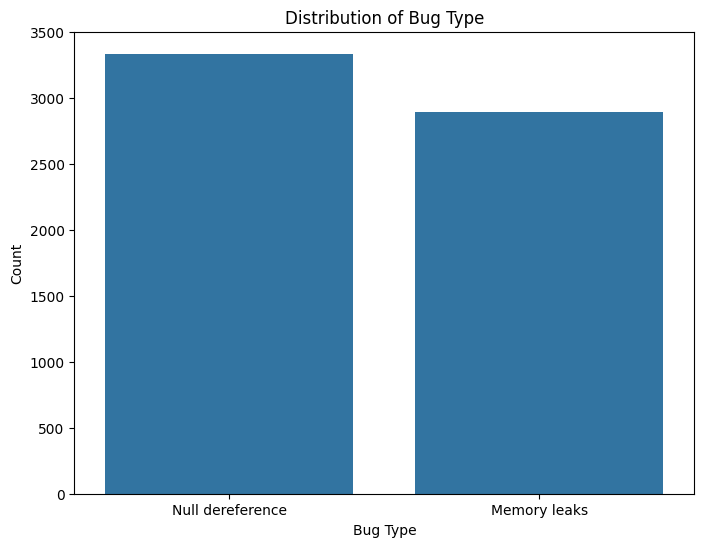

In [ ]:
bug_counts = features_df['bug_type'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=bug_counts.index, y=bug_counts.values)
plt.title('Distribution of Bug Type')
plt.xlabel('Bug Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Null dereference', 'Memory leaks'])  # Adjust labels if necessary
plt.show()

Class imbalance not that much of an issue 👍

In [ ]:
# TODO missing the response variable
X = features_df.drop(columns=["bug_type", "file_name"])
y = features_df["bug_type"]

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Make use of Logistic Regression as the baseline model.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Baseline Model Accuracy (Logistic Regression): 0.71


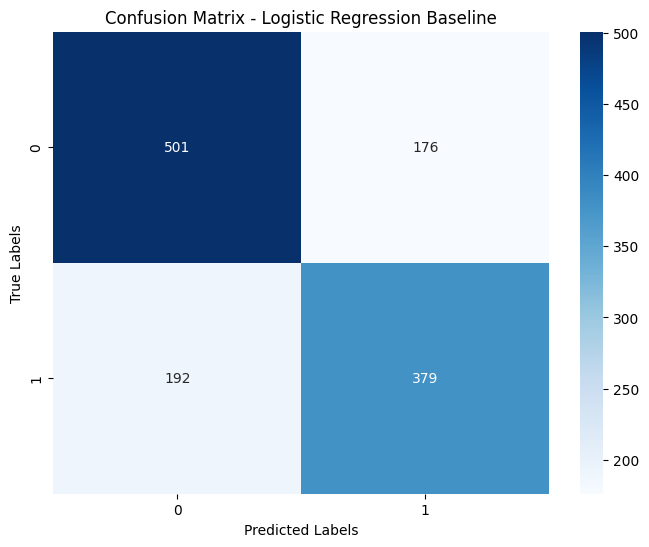

In [ ]:
# Create a Logistic Regression model as the baseline
baseline_model = LogisticRegression(max_iter=200, random_state=42)

# Train the baseline model
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred = baseline_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Baseline Model Accuracy (Logistic Regression): {accuracy:.2f}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d') # xticklabels=data.target_names, yticklabels=data.target_names
plt.title('Confusion Matrix - Logistic Regression Baseline')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Try out the Ensemble methods.

In [ ]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train the classifier
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions
y_pred = rf_classifier.predict(X_test)

In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8405448717948718


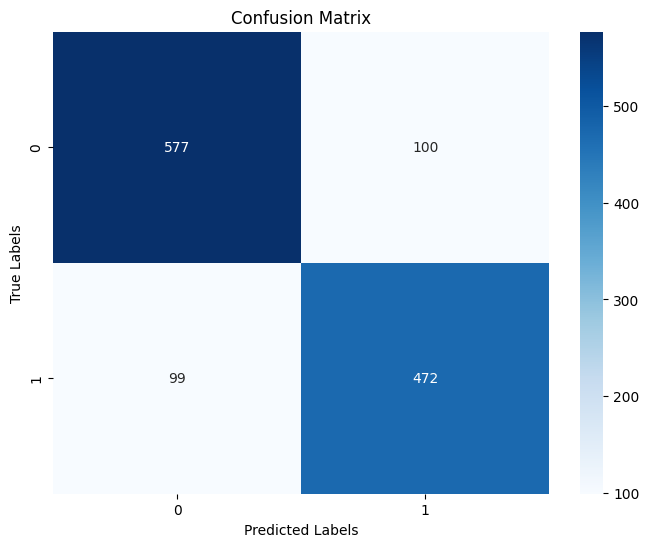

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d') # TODO add the code - xticklabels=data.target_names, yticklabels=data.target_names
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Might be worthwhile to see which features are important

ROC-AUC Score: 0.92


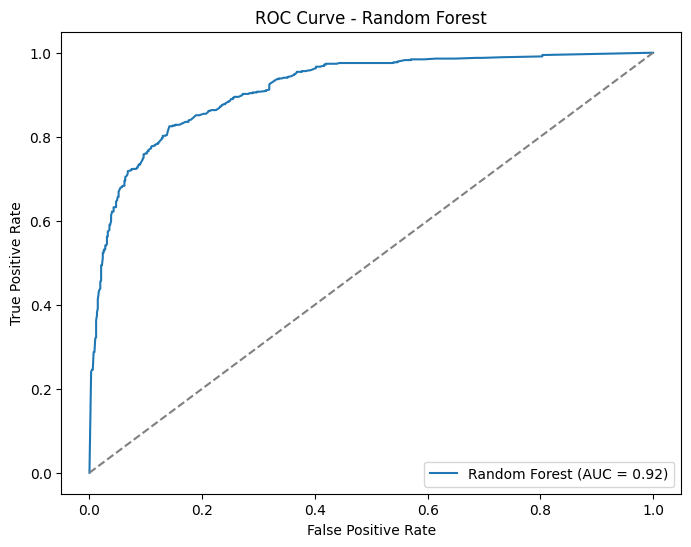

In [ ]:
y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

falsepr, truepr, thresholds = roc_curve(y_test, y_pred_proba_rf)

roc_auc = auc(falsepr, truepr)
print(f'ROC-AUC Score: {roc_auc:.2f}')

plt.figure(figsize=(8, 6))
plt.plot(falsepr, truepr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

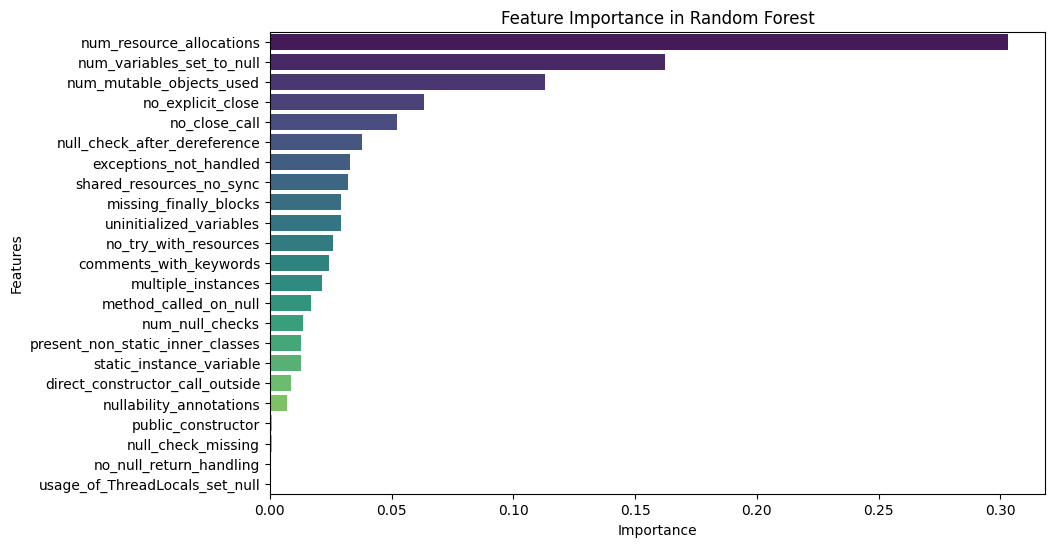

In [ ]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Is it worth trying out Neural Nets? i have been looking at random forest and it looks pretty good: ROC-AUC Score - Random Forest: 0.92


Random Forest (Alison) :I have added the random forest ROC-AUC Score ont his notebook. I also played with the Random forest in a notebook aside and looked at its ROC curve, I removed variables that brought little to no importance, I also added the grid search and tried to find the best parameters and used those refitted the model and got 0.84 which is lower than 0.92 but I think it is better with generalized data and is not overfitting. This is the link to that notebook: [RandomForest](https://colab.research.google.com/drive/1qeI5ublOIys-3hMgFQLR2z4Uki9aUV_E?usp=sharing). I also added it to the Google colab notebooks